<html>
    <h1 style="color:Green;">Transformer-MCDO Model</h1>
</html>

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 2.1508 - val_loss: 0.3590
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 1.2193 - val_loss: 1.1754
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 1.5289 - val_loss: 0.7366
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 1.2331 - val_loss: 0.3090
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 1.1381 - val_loss: 0.3762
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 1.1089 - val_loss: 0.5770
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.4412 - val_loss: 0.7848
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 1.0382 - val_loss: 0.9288
Epoch 9/100
1/1 [==============================] - 0s 51ms/step - loss: 0.5498 - val_loss: 1.1090
Epoch 10/100
1/1 [==============================] - 0s 51ms/step - loss: 0.4375 - val_loss: 1.2807
Epoch 11/100
1/1 [===

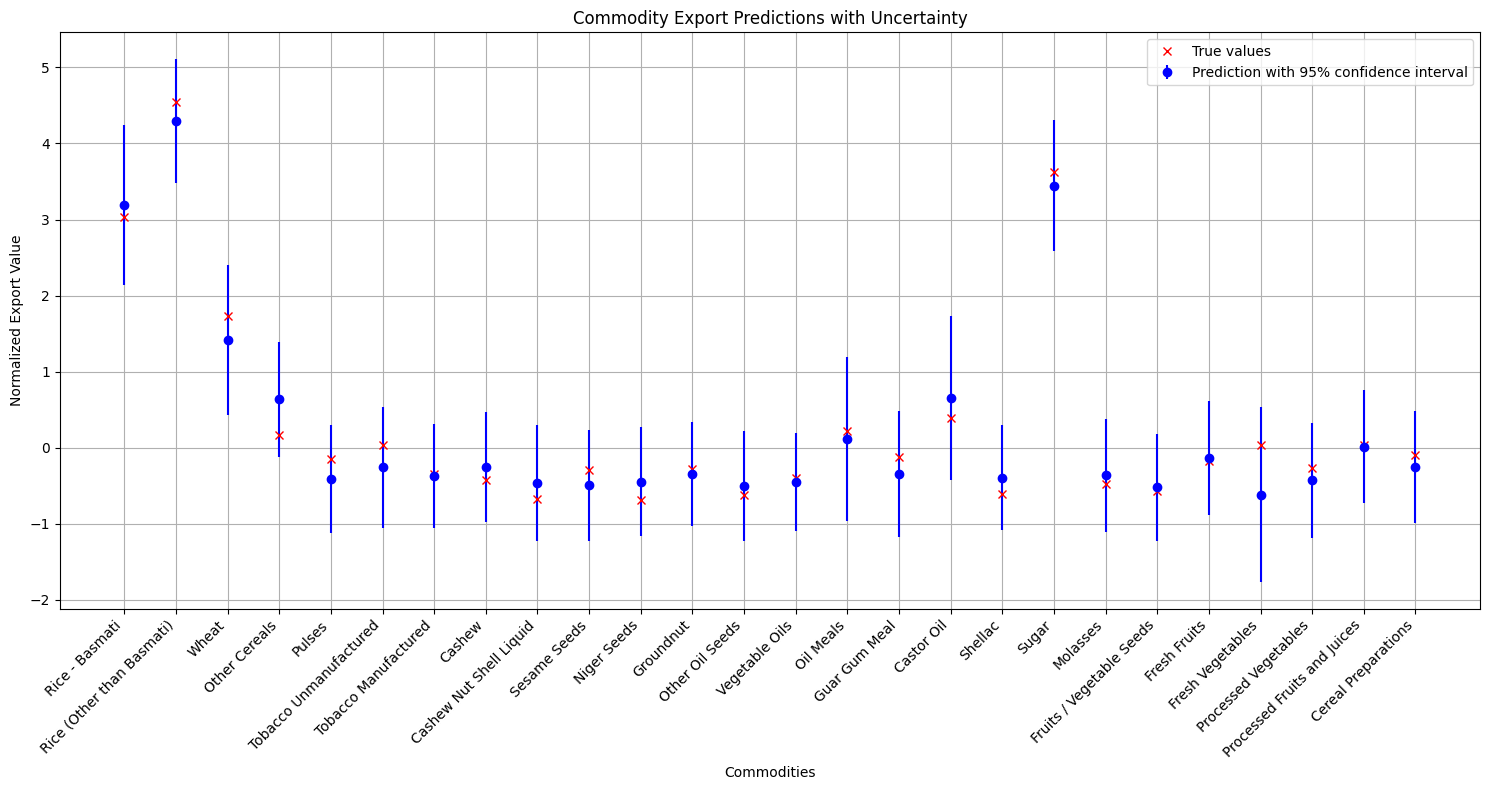

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Sequential, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerMCDO(Model):
    def __init__(self, input_dim, embed_dim=32, num_heads=4, ff_dim=32, num_transformer_blocks=2, dropout_rate=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.embedding = Dense(embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_transformer_blocks)
        ]
        self.dropout = Dropout(dropout_rate)
        self.global_average = tf.keras.layers.GlobalAveragePooling1D()
        self.final_output = Dense(1)
        
    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = tf.expand_dims(x, axis=1)  # Add sequence dimension
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = self.dropout(x, training=training)
        x = self.global_average(x)
        return self.final_output(x)
    
    def predict_with_uncertainty(self, X, num_samples=100):
        predictions = np.zeros((num_samples, X.shape[0]))
        
        for i in range(num_samples):
            predictions[i, :] = self(X, training=True).numpy().flatten()
        
        mean_prediction = np.mean(predictions, axis=0)
        std_prediction = np.std(predictions, axis=0)
        
        return mean_prediction, std_prediction

def load_data():
    data = {
        'Commodity': [
            'Rice - Basmati', 'Rice (Other than Basmati)', 'Wheat', 'Other Cereals',
            'Pulses', 'Tobacco Unmanufactured', 'Tobacco Manufactured', 'Cashew',
            'Cashew Nut Shell Liquid', 'Sesame Seeds', 'Niger Seeds', 'Groundnut',
            'Other Oil Seeds', 'Vegetable Oils', 'Oil Meals', 'Guar Gum Meal',
            'Castor Oil', 'Shellac', 'Sugar', 'Molasses', 'Fruits / Vegetable Seeds',
            'Fresh Fruits', 'Fresh Vegetables', 'Processed Vegetables',
            'Processed Fruits and Juices', 'Cereal Preparations'
        ],
        '2018-2019': [2247.34, 1577.02, 20.84, 208.83, 155.13, 291.99, 200.98, 311.77,
                      2.44, 289.83, 5.11, 209.77, 49.37, 58.14, 591.9, 355.38, 445.41,
                      22.27, 490.83, 27.76, 78.52, 293.03, 425.53, 150.83, 299.22, 267.44],
        '2019-2020': [2032.1, 1021.77, 33.14, 97.22, 120.09, 274.61, 211.18, 281.3,
                      1.55, 254.97, 5.41, 190.32, 30.07, 65.97, 430.11, 268.09, 523.11,
                      21.7, 808.32, 36.7, 67.01, 277.68, 408.81, 152.54, 298.57, 273.45],
        '2020-2021': [2123.58, 1964.87, 108.77, 212.99, 154.76, 264.23, 157.66, 168.72,
                      1.03, 224.11, 12.02, 236.51, 35.35, 131.22, 461.65, 122.03, 438.01,
                      36.91, 1364.08, 44.49, 72.09, 230.65, 440.63, 213.87, 321.88, 280.21],
        '2021-2022': [1659.6, 2968.77, 630.15, 467.42, 135.25, 288.53, 174.91, 222.02,
                      1.89, 188.05, 4.77, 246.42, 14.04, 99.22, 471.65, 178.85, 615.62,
                      44.86, 1820.68, 95.4, 65.81, 301.3, 435.41, 213.77, 370.12, 314.92],
        '2022-2023': [2279.66, 3207.29, 1487.47, 524.85, 329.55, 446.72, 212.77, 157.09,
                      5.09, 242.87, 2.82, 245.57, 39.76, 178.9, 556.61, 343.65, 662.93,
                      48.8, 2649.0, 127.28, 73.03, 313.46, 439.52, 254.01, 440.62, 359.31]
    }
    return pd.DataFrame(data)

def prepare_data(df):
    # Normalize the data
    years = df.columns[1:].tolist()
    values = df[years].values
    mean = np.mean(values)
    std = np.std(values)
    normalized_values = (values - mean) / std
    
    X_list = []
    y_list = []
    commodities = []
    
    for i in range(len(df)):
        values = normalized_values[i]
        X = values[:-1].reshape(1, -1)  # Use all but last year as features
        y = values[-1]  # Use last year as target
        
        X_list.append(X)
        y_list.append(y)
        commodities.append(df['Commodity'].iloc[i])
    
    X = np.vstack(X_list)
    y = np.array(y_list)
    
    return X, y, commodities, mean, std

def plot_predictions(commodities, y_true, y_pred, y_std):
    plt.figure(figsize=(15, 8))
    indices = np.arange(len(commodities))
    
    plt.errorbar(indices, y_pred, yerr=2*y_std, fmt='o', color='b', 
                label='Prediction with 95% confidence interval')
    plt.plot(indices, y_true, 'rx', label='True values')
    
    plt.xticks(indices, commodities, rotation=45, ha='right')
    plt.xlabel('Commodities')
    plt.ylabel('Normalized Export Value')
    plt.title('Commodity Export Predictions with Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return plt.gcf()

def main():
    # Load and prepare data
    df = load_data()
    X, y, commodities, mean, std = prepare_data(df)
    
    # Create and train model
    model = TransformerMCDO(
        input_dim=X.shape[1],
        embed_dim=32,
        num_heads=4,
        ff_dim=32,
        num_transformer_blocks=2,
        dropout_rate=0.1
    )
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    
    # Train model
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    
    # Make predictions with uncertainty
    mean_pred, std_pred = model.predict_with_uncertainty(X)
    
    # Plot results
    fig = plot_predictions(commodities, y, mean_pred, std_pred)
    
    # Print performance metrics
    mse = np.mean((y - mean_pred) ** 2)
    print(f"\nModel Performance:")
    print(f"MSE (normalized): {mse:.4f}")
    print(f"MSE (original scale): {mse * (std ** 2):.4f}")
    
    # Print commodities with highest uncertainty
    uncertainty_df = pd.DataFrame({
        'Commodity': commodities,
        'Uncertainty': std_pred
    }).sort_values('Uncertainty', ascending=False)
    
    print("\nTop 5 commodities with highest prediction uncertainty:")
    print(uncertainty_df.head())
    
    return model, mean_pred, std_pred, history, fig

if __name__ == "__main__":
    model, mean_pred, std_pred, history, fig = main()

In [6]:
def evaluate_predictions(commodities, y_true, y_pred, y_std, mean, std):
    # Convert normalized values back to original scale
    y_true_original = y_true * std + mean
    y_pred_original = y_pred * std + mean
    y_std_original = y_std * std
    
    # Create evaluation DataFrame
    evaluation_df = pd.DataFrame({
        'Commodity': commodities,
        'True_Value': y_true_original,
        'Predicted_Value': y_pred_original,
        'Uncertainty': y_std_original,
        'Confidence_Interval_Lower': y_pred_original - 2*y_std_original,
        'Confidence_Interval_Upper': y_pred_original + 2*y_std_original,
        'Absolute_Error': np.abs(y_true_original - y_pred_original),
        'Percentage_Error': np.abs((y_true_original - y_pred_original) / y_true_original) * 100
    })
    
    # Calculate overall metrics
    metrics = {
        'Mean Absolute Error': np.mean(evaluation_df['Absolute_Error']),
        'Mean Percentage Error': np.mean(evaluation_df['Percentage_Error']),
        'Root Mean Square Error': np.sqrt(np.mean((y_true_original - y_pred_original)**2)),
        'Mean Uncertainty': np.mean(y_std_original),
        'Median Uncertainty': np.median(y_std_original)
    }
    
    return evaluation_df, metrics

# After running the main model:
df = load_data()
X, y, commodities, mean, std = prepare_data(df)
model = TransformerMCDO(
    input_dim=X.shape[1],
    embed_dim=32,
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=2,
    dropout_rate=0.1
)
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
mean_pred, std_pred = model.predict_with_uncertainty(X)

# Generate evaluation report
eval_df, metrics = evaluate_predictions(commodities, y, mean_pred, std_pred, mean, std)

# Print detailed evaluation results
print("\nOverall Model Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.2f}")

print("\nDetailed Predictions and Uncertainties:")
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(eval_df.sort_values('Absolute_Error', ascending=False))

# Print commodities with highest uncertainty
print("\nTop 5 Most Uncertain Predictions:")
print(eval_df.nlargest(5, 'Uncertainty')[['Commodity', 'True_Value', 'Predicted_Value', 'Uncertainty']])

# Print most accurate predictions
print("\nTop 5 Most Accurate Predictions:")
print(eval_df.nsmallest(5, 'Absolute_Error')[['Commodity', 'True_Value', 'Predicted_Value', 'Absolute_Error']])

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 5.0959 - val_loss: 1.1238
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 1.3855 - val_loss: 1.5181
Epoch 3/100
1/1 [==============================] - 0s 87ms/step - loss: 1.4557 - val_loss: 2.6875
Epoch 4/100
1/1 [==============================] - 0s 53ms/step - loss: 1.6026 - val_loss: 3.1026
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 2.3738 - val_loss: 2.7207
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 1.3189 - val_loss: 2.1202
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 1.5126 - val_loss: 1.4547
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 1.2420 - val_loss: 1.0034
Epoch 9/100
1/1 [==============================] - 0s 49ms/step - loss: 0.9767 - val_loss: 0.6964
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 0.8858 - val_loss: 0.5031
Epoch 11/100
1/1 [===